In [1]:
# import Libraries
import os

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision
from tqdm.notebook import tqdm

from PIL import Image

from torch import nn
from torchvision.io import read_image, ImageReadMode
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split


In [2]:
# Paths to directories

train = "/kaggle/input/whu-building-dataset/WHU building/train"
test = "/kaggle/input/whu-building-dataset/WHU building/test"
valid = "/kaggle/input/whu-building-dataset/WHU building/val"

In [3]:
# helper function for data visualization
def visualize(**images):
    n_images = len(images)
    plt.figure(figsize=(10,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.axis(False)
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image.permute(1,2,0))
    plt.show()

In [4]:
# Helper function for plotting loss
def plot_loss(losses, title="Training Loss"):
    # Plot the loss curve
    plt.plot(losses)

    sns.despine()
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

In [5]:
# Loading Dataset
class WHUBuildingDataset(Dataset):
    ''' Load WHU building dataset, Ouputs image and its corresponding segmentation map'''
    def __init__(self, category='train', transform=None, target_transform=None):
        assert category in ['train', 'test', 'val'], "Valid Categories: train, test, val"
        
        self.BASEDIR = '../input/whu-building-dataset/WHU building'
        self.FOLDER = f"{self.BASEDIR}/{category}"
        self.image_idx = os.listdir(f"{self.FOLDER}/A")
        self.n_images = len(self.image_idx)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.n_images

    def __getitem__(self, idx):
        image_name = self.image_idx[idx]
        img = read_image(f"{self.FOLDER}/A/{image_name}", mode=ImageReadMode.RGB) / 255 
        seg = read_image(f"{self.FOLDER}/OUT/{image_name}", mode=ImageReadMode.GRAY) / 255

        if self.transform:
            img = self.transform(img)
            seg = self.transform(seg)

        if self.target_transform:
            seg = self.target_transform(mask)
            
        return img, seg 

In [6]:
# Variables
BATCH_SIZE = 2
NUM_WORKERS = 0

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' 

if DEVICE == 'cuda':
    device_name = torch.cuda.get_device_name(0)
    print(f"Setting compute device to {DEVICE} on {device_name}")


Setting compute device to cuda on Tesla P100-PCIE-16GB


In [7]:
# Create and load dataset

dataset = WHUBuildingDataset()
# Take a subset of data
dataset, _ = random_split(dataset, [0.4, 0.6])

dataloader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True)

Length of train dataset: 1896
Shape of Image: torch.Size([3, 512, 512])
Shape of Segmentation mask: torch.Size([1, 512, 512])


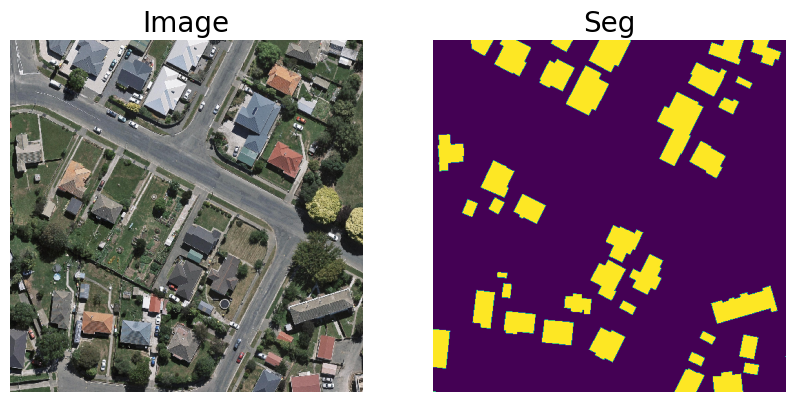

In [8]:
image, seg = next(iter(dataloader))
print(f"Length of train dataset: {len(dataloader) * BATCH_SIZE}")
print(f"Shape of Image: {image[0].shape}")
print(f"Shape of Segmentation mask: {seg[0].shape}")
visualize(image=image[0], seg=seg[0])

In [9]:
image.min(), image.max(), seg.min(), seg.max()

(tensor(0.), tensor(1.), tensor(0.), tensor(1.))

## Attention Unet Model

In [10]:
class ConvBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()

        # number of input channels is a number of filters in the previous layer
        # number of output channels is a number of filters in the current layer
        # "same" convolutions
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class UpConv(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()

        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x


class AttentionBlock(nn.Module):
    """Attention block with learnable parameters"""

    def __init__(self, F_g, F_l, n_coefficients):
        """
        :param F_g: number of feature maps (channels) in previous layer
        :param F_l: number of feature maps in corresponding encoder layer, transferred via skip connection
        :param n_coefficients: number of learnable multi-dimensional attention coefficients
        """
        super(AttentionBlock, self).__init__()

        self.W_gate = nn.Sequential(
            nn.Conv2d(F_g, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(n_coefficients, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, gate, skip_connection):
        """
        :param gate: gating signal from previous layer
        :param skip_connection: activation from corresponding encoder layer
        :return: output activations
        """
        g1 = self.W_gate(gate)
        x1 = self.W_x(skip_connection)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = skip_connection * psi
        return out


class AttentionUNet(nn.Module):

    def __init__(self, img_ch=3, output_ch=1):
        super(AttentionUNet, self).__init__()

        self.MaxPool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = ConvBlock(img_ch, 64)
        self.Conv2 = ConvBlock(64, 128)
        self.Conv3 = ConvBlock(128, 256)
        self.Conv4 = ConvBlock(256, 512)
#         self.Conv5 = ConvBlock(512, 1024)

#         self.Up5 = UpConv(1024, 512)
#         self.Att5 = AttentionBlock(F_g=512, F_l=512, n_coefficients=256)
#         self.UpConv5 = ConvBlock(1024, 512)

        self.Up4 = UpConv(512, 256)
        self.Att4 = AttentionBlock(F_g=256, F_l=256, n_coefficients=128)
        self.UpConv4 = ConvBlock(512, 256)

        self.Up3 = UpConv(256, 128)
        self.Att3 = AttentionBlock(F_g=128, F_l=128, n_coefficients=64)
        self.UpConv3 = ConvBlock(256, 128)

        self.Up2 = UpConv(128, 64)
        self.Att2 = AttentionBlock(F_g=64, F_l=64, n_coefficients=32)
        self.UpConv2 = ConvBlock(128, 64)

        self.Conv = nn.Conv2d(64, output_ch, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        """
        e : encoder layers
        d : decoder layers
        s : skip-connections from encoder layers to decoder layers
        """
        e1 = self.Conv1(x)

        e2 = self.MaxPool(e1)
        e2 = self.Conv2(e2)

        e3 = self.MaxPool(e2)
        e3 = self.Conv3(e3)

        e4 = self.MaxPool(e3)
        e4 = self.Conv4(e4)

#         e5 = self.MaxPool(e4)
#         e5 = self.Conv5(e5)

#         d5 = self.Up5(e4)

#         s4 = self.Att5(gate=d5, skip_connection=e4)
#         d5 = torch.cat((s4, d5), dim=1) # concatenate attention-weighted skip connection with previous layer output
#         d5 = self.UpConv5(d5)

        d4 = self.Up4(e4)
        s3 = self.Att4(gate=d4, skip_connection=e3)
        d4 = torch.cat((s3, d4), dim=1)
        d4 = self.UpConv4(d4)

        d3 = self.Up3(d4)
        s2 = self.Att3(gate=d3, skip_connection=e2)
        d3 = torch.cat((s2, d3), dim=1)
        d3 = self.UpConv3(d3)

        d2 = self.Up2(d3)
        s1 = self.Att2(gate=d2, skip_connection=e1)
        d2 = torch.cat((s1, d2), dim=1)
        d2 = self.UpConv2(d2)

        out = self.Conv(d2)

        return out
    
# Define the ensemble model with 3 U-Nets
class EnsembleUNet(nn.Module):
    def __init__(self, num_classes=1):
        super(EnsembleUNet, self).__init__()
        # Instantiate 3 U-Nets
        self.unet1 = AttentionUNet()
        self.unet2 = AttentionUNet()
        self.unet3 = AttentionUNet()
        # Define the output layer for the ensemble model
        self.output_layer = nn.Conv2d(3*num_classes, num_classes, kernel_size=1)
    
    def forward(self, x):
        # Pass the input through each U-Net
        output1 = self.unet1(x)
        output2 = self.unet2(x)
        output3 = self.unet3(x)
        # Concatenate the outputs from the 3 U-Nets along the channel dimension
        combined_output = torch.cat([output1, output2, output3], dim=1)
        # Pass the concatenated output through the output layer
        output = self.output_layer(combined_output)
        return output

In [11]:
# Loss Function 
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, pred, act):
        loss_fn = nn.MSELoss()
        loss = torch.sqrt(loss_fn(pred, act))

        return loss

In [33]:
# Training Variables
EPOCHS = 5
LEARNING_RATE = 1e-3
SAVE_MODEL = True
VERSION = 0.1

In [13]:
model = EnsembleUNet().to(DEVICE)
criterion = RMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [14]:
# Number of trainable parameters
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters are: {pytorch_total_params}")

Number of trainable parameters are: 25954882


In [15]:
def train(
    model=model,
    dataloader=dataloader,
    criterion=criterion, 
    optimizer=optimizer,
    device=DEVICE,
    epochs=EPOCHS
):
    model.train() # Set the model in training mode
    loss_list = []
    for epoch in range(epochs):
        running_loss = 0
        n_batch = 0
        for idx, (img, seg) in tqdm(enumerate(dataloader), total=len(dataloader)):
            img = img.to(device, non_blocking=True) # Send batch images to compute device
            true_seg = seg.to(torch.float32).to(device, non_blocking=True)
            # Forward pass
            pred = model(img) # Model Output
            # Compute Loss
            loss = criterion(pred, true_seg)
            running_loss += loss.item()
            n_batch += 1
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
        epoch_loss = running_loss / n_batch
        loss_list.append(epoch_loss)
        
        print(f"Epoch {epoch + 1 }: Training Loss {epoch_loss:.6f}")
    
    return loss_list


In [16]:
losses = train(model)

  0%|          | 0/948 [00:00<?, ?it/s]

Epoch 1: Training Loss 0.242347


  0%|          | 0/948 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
plot_loss(losses, "Training Loss of Attention Unet model")

In [34]:
# Save the model for later use
if SAVE_MODEL:
    torch.save(model, f"unetv{VERSION}.pth")

In [17]:
image, seg = next(iter(dataloader))
pred = model(image.to(DEVICE))
pred = pred.cpu().detach()

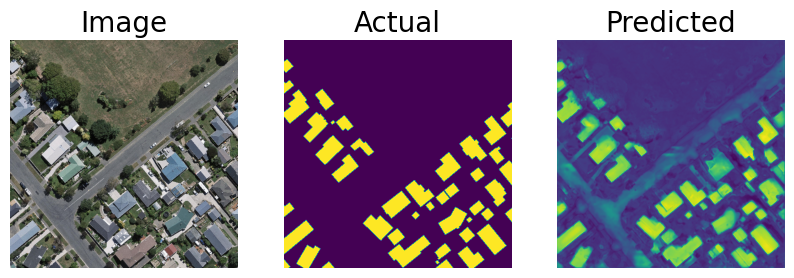

In [18]:
visualize(image=image[0], actual=seg[0], predicted=pred[0])

## Testing

In [26]:
test_dataset = WHUBuildingDataset(category='test')
test_dataset, _ = random_split(test_dataset, [0.4, 0.6])
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True)

In [27]:
def test(model=model, dataloader=test_dataloader, device=DEVICE):
    
    model.eval() # Set model to evaluation mode
    running_loss = 0
    n_batch = 0
    with torch.no_grad():
        for idx, (img, seg) in tqdm(enumerate(dataloader), total=len(dataloader)):
            img = img.to(device, non_blocking=True) # Send batch images to compute device
            true_seg = seg.to(torch.float32).to(device, non_blocking=True)
            # Forward pass
            pred = model(img) # Model Output
            # Compute Loss
            loss = criterion(pred, true_seg)
            running_loss += loss.item()
            n_batch += 1

        epoch_loss = running_loss / n_batch

    print(f"Testing Loss {epoch_loss:.6f}")
    
    return epoch_loss

In [28]:
test_loss = test()

  0%|          | 0/484 [00:00<?, ?it/s]

Testing Loss 0.168278


In [29]:
test_loss

0.168277829773878

In [31]:
image, seg = next(iter(test_dataloader))
pred = model(image.to(DEVICE))
pred = pred.cpu().detach()

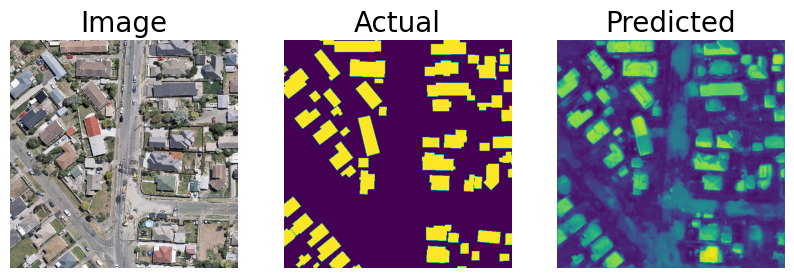

In [32]:
visualize(image=image[0], actual=seg[0], predicted=pred[0])